# Taller de repaso: Aprendizaje no supervisado

## Preparación del notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
#!pip install kneed
from kneed import KneeLocator

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FactorAnalysis

#!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Lectura del dataset

Este conjunto de datos contiene una encuesta sobre la satisfacción de los pasajeros de una compañía aérea. ¿Qué factores están altamente correlacionados con un pasajero satisfecho (o insatisfecho)?

In [3]:
# Lectura del dataset
df = pd.read_csv('https://raw.githubusercontent.com/mlondono-oc/LEA2_20232/main/Modulo3/data/train.csv')
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [4]:
#Información general de las variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [5]:
# Eliminación de variables no significativas
df.drop(['Unnamed: 0', 'id', ], axis=1, inplace=True)

## EDA

In [ ]:
# Comprobación de valores nulos
df.isnull().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

<Axes: >

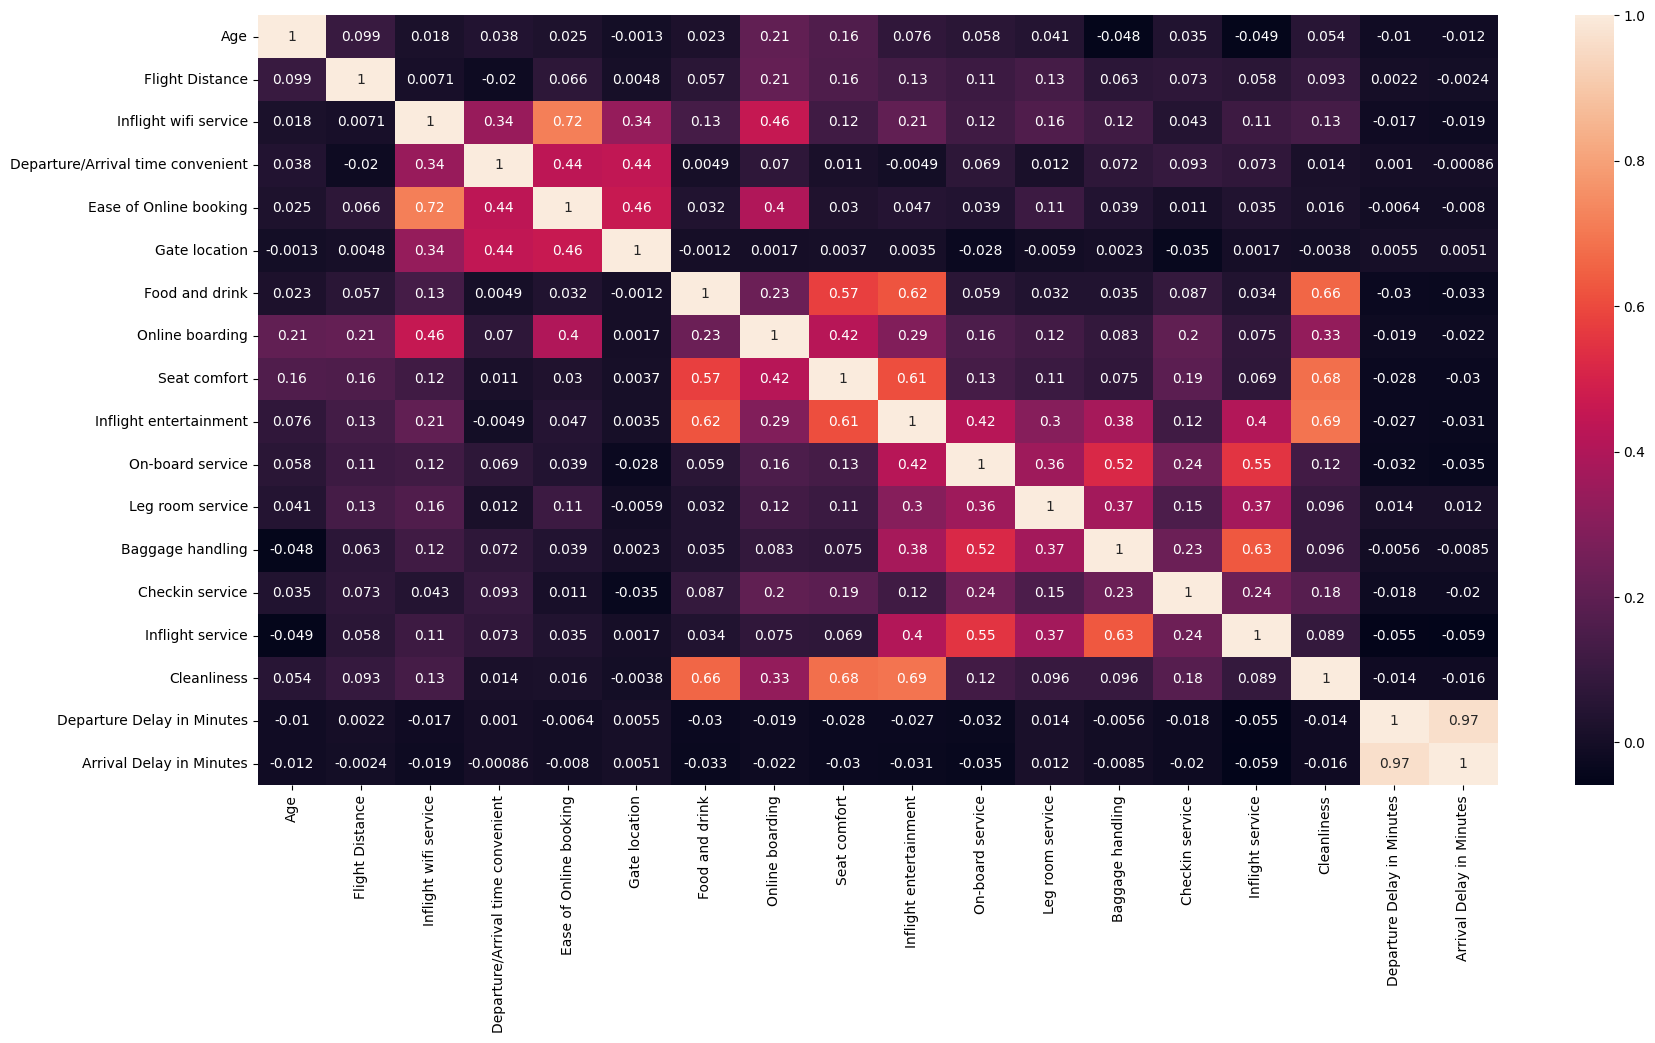

In [ ]:
# Matriz de correlación
plt.figure(figsize=(20,10))
c= df.corr()
sns.heatmap(c, annot=True)

In [6]:
# Eliminación de columna altamente correlacionada y con valores NaN
df.drop(['Arrival Delay in Minutes'], axis=1, inplace=True)

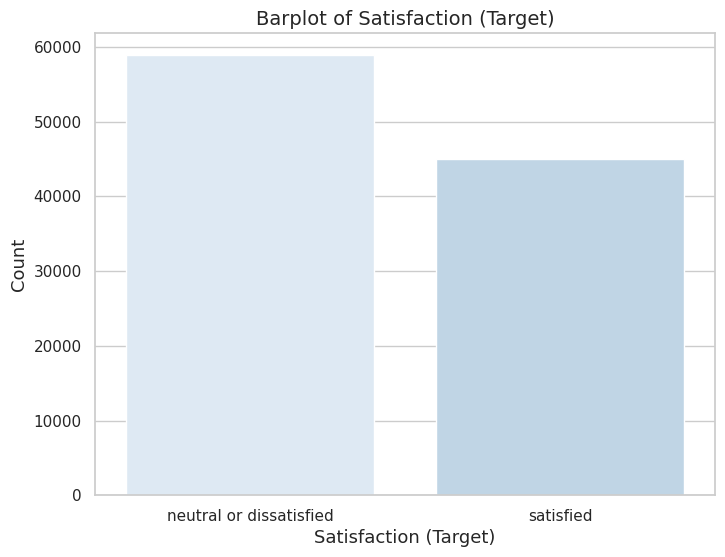

In [ ]:
# Estilo de las gráficas
sns.set_theme(style='whitegrid', palette='Blues')

# Variable satisfacción
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='satisfaction', data=df)
plt.title('Barplot of Satisfaction (Target)', fontsize=14)
plt.xlabel('Satisfaction (Target)', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.show()

In [ ]:
# Veamos primero la puntuación media de cada clase, en las 14 variables que se encuestaron
eco = df[df['Class']=='Eco'][df.columns[6:20]].mean().mean()
eco_plus = df[df['Class']=='Eco Plus'][df.columns[6:20]].mean().mean()
business = df[df['Class']=='Business'][df.columns[6:20]].mean().mean()
print(eco, eco_plus, business)

3.067027795180539 3.0686835182431653 3.4301678388057124


In [ ]:
df.groupby('Class')[df.columns[6:20]].mean()

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
Class,,,,,,,,,,,,,,
Business,2.775315,2.905910,2.913964,2.982926,3.323165,3.716541,3.760858,3.635437,3.679472,3.644498,3.842907,3.519178,3.844579,3.477600
Eco,2.675067,3.199123,2.605241,2.971954,3.086277,2.812985,3.138838,3.098256,3.120355,3.085720,3.450551,3.122002,3.463921,3.108097
Eco Plus,2.767948,3.217507,2.661996,2.967574,3.122631,2.889245,3.183747,3.141713,3.047638,3.061382,3.363758,3.017214,3.388444,3.130771


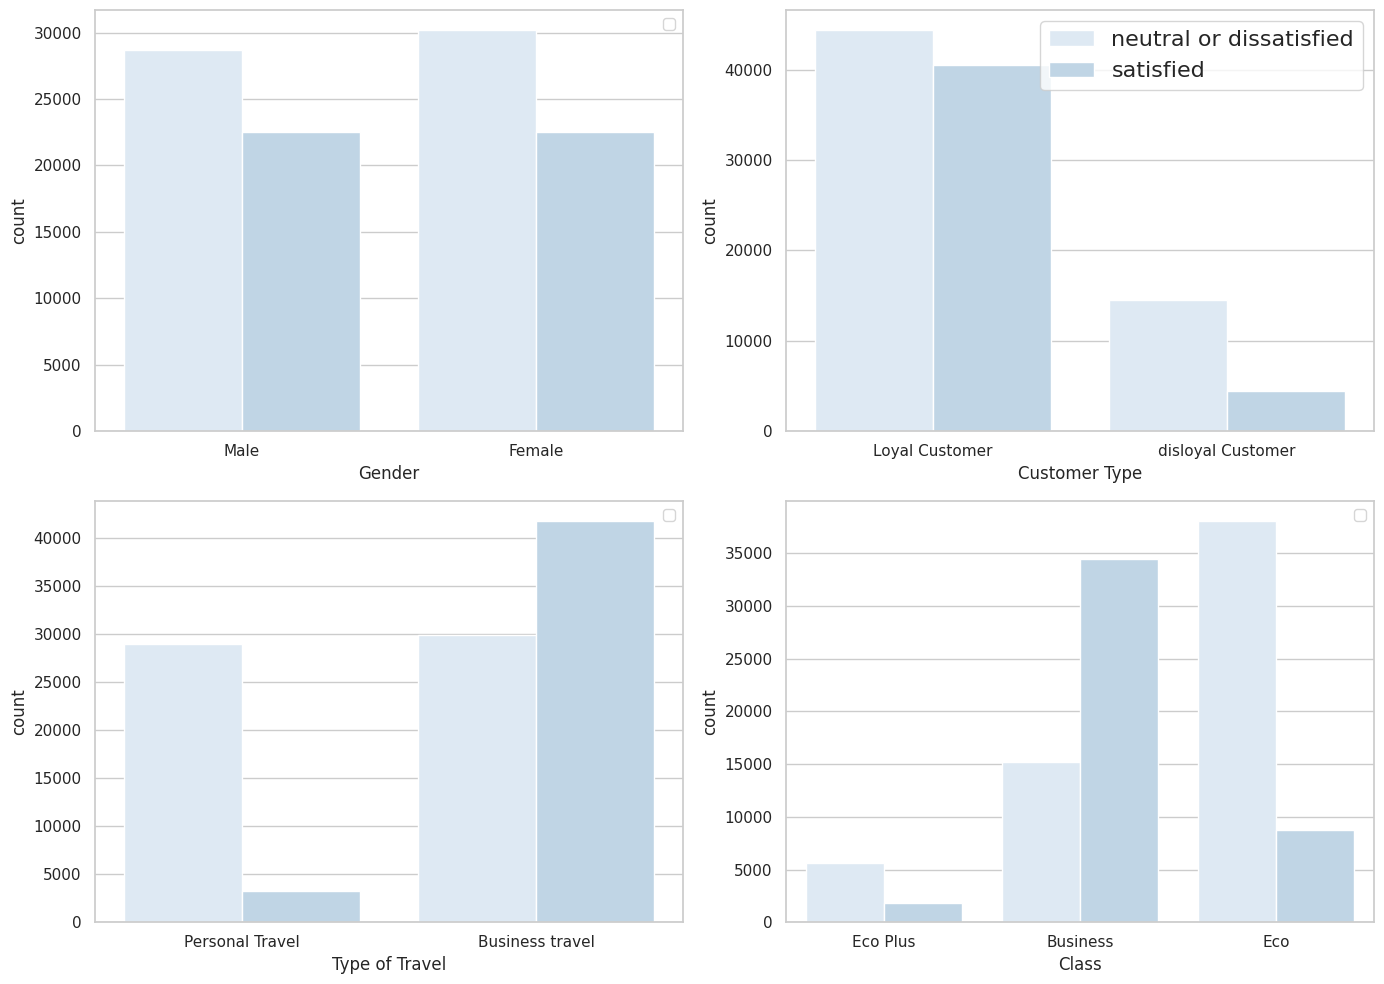

In [ ]:
# Variable Categoricas
cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axs = axs.ravel()

i=0
for col in cat_cols:

    # define location
    plt.subplot(2, 2, i+1)

    # create plot
    ax = plt.gca()
    axs[i] = sns.countplot(x = col, hue = 'satisfaction', data = df)

    # remove legend
    ax.legend('')

    i += 1

# add legend
axs[1].legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.show()

In [7]:
# Codificación de variable satisfacción
df['satisfaction'] = df['satisfaction'].map({'neutral or dissatisfied':0, 'satisfied':1})

In [ ]:
#  Revisión Clase Eco
eco_proportion = len(df[df['Class']=='Eco'])/len(df)
bad_proportion = len(df[df['Class']=='Eco']['satisfaction']==0)/len(df[df['satisfaction']==0])
print(eco_proportion*100, bad_proportion*100)

44.9886433631044 79.39163368943086


## Pre procesamiento de los datos

In [8]:
# Metodología 1
train_df1 = df.copy()
train_df1['Gender'] = train_df1['Gender'].map({'Female':0, 'Male':1})
train_df1['Customer Type'] = train_df1['Customer Type'].map({'disloyal Customer':0, 'Loyal Customer':1})
train_df1['Type of Travel'] = train_df1['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})
train_df1['Class'] = train_df1['Class'].map({'Eco':1, 'Eco Plus':2, 'Business':3})

train_df1.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,1,1,13,0,2,460,3,4,3,1,...,5,5,4,3,4,4,5,5,25,0
1,1,0,25,1,3,235,3,2,3,3,...,1,1,1,5,3,1,4,1,1,0
2,0,1,26,1,3,1142,2,2,2,2,...,5,5,4,3,4,4,4,5,0,1


In [9]:
# Metodología 2
train_df2 = df.copy()
train_df2['Gender'] = train_df2['Gender'].map({'Female':0, 'Male':1})
train_df2['Customer Type'] = train_df2['Customer Type'].map({'disloyal Customer':0, 'Loyal Customer':1})
train_df2['Type of Travel'] = train_df2['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})

# Calcular la frecuencia de cada categoría Class
frecuencia = train_df2['Class'].value_counts(normalize=True)
# Aplicar la codificación de frecuencia
train_df2['Class'] = train_df2['Class'].map(frecuencia)

train_df2.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,1,1,13,0,0.072124,460,3,4,3,1,...,5,5,4,3,4,4,5,5,25,0
1,1,0,25,1,0.477989,235,3,2,3,3,...,1,1,1,5,3,1,4,1,1,0
2,0,1,26,1,0.477989,1142,2,2,2,2,...,5,5,4,3,4,4,4,5,0,1


In [10]:
train_df1.shape

(103904, 22)

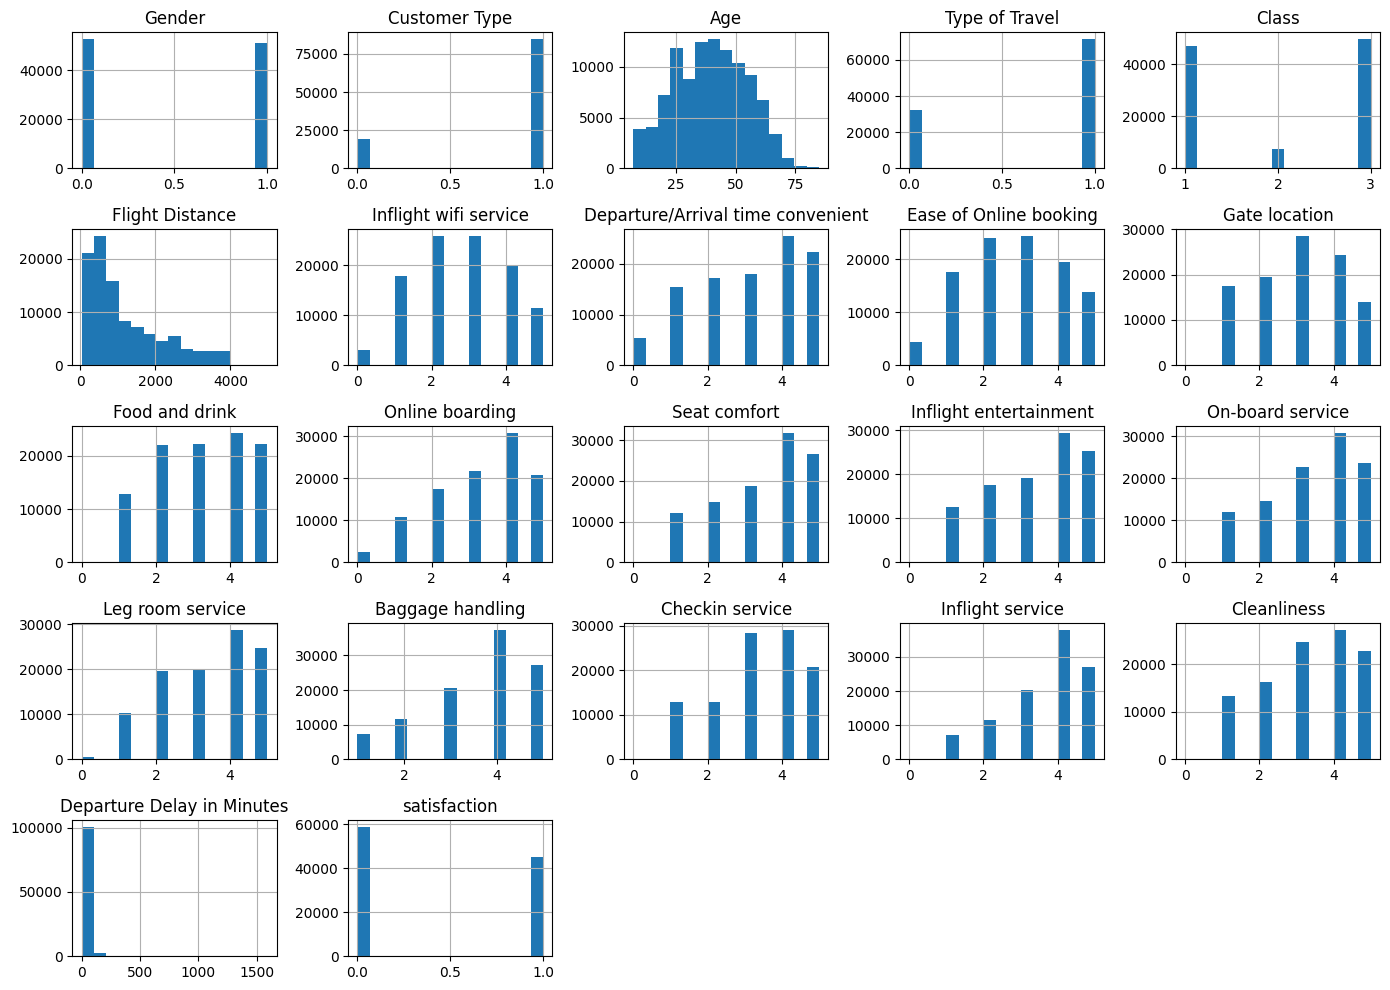

In [11]:
train_df1.hist(figsize=(14,10), bins=15)
plt.tight_layout()
plt.show()

In [12]:
# Escalado de variables numéricas
train_cols = train_df1[['Age', 'Flight Distance', 'Departure Delay in Minutes']]

scaler = StandardScaler()
scaled_train_df1 = pd.DataFrame(scaler.fit_transform(train_cols), columns = train_cols.columns)
scaled_train_df1.head(3)

,Age,Flight Distance,Departure Delay in Minutes
0,-1.745279,-0.731539,0.266393
1,-0.951360,-0.957184,-0.361375
2,-0.885200,-0.047584,-0.387532


In [13]:
#  Union de data numéricas  y categórica
cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes']
train_df1[cols] = scaled_train_df1
train_df2[cols] = scaled_train_df1
train_df1.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,1,1,-1.745279,0,2,-0.731539,3,4,3,1,...,5,5,4,3,4,4,5,5,0.266393,0
1,1,0,-0.951360,1,3,-0.957184,3,2,3,3,...,1,1,1,5,3,1,4,1,-0.361375,0
2,0,1,-0.885200,1,3,-0.047584,2,2,2,2,...,5,5,4,3,4,4,4,5,-0.387532,1


In [14]:
train_df2.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,1,1,-1.745279,0,0.072124,-0.731539,3,4,3,1,...,5,5,4,3,4,4,5,5,0.266393,0
1,1,0,-0.951360,1,0.477989,-0.957184,3,2,3,3,...,1,1,1,5,3,1,4,1,-0.361375,0
2,0,1,-0.885200,1,0.477989,-0.047584,2,2,2,2,...,5,5,4,3,4,4,4,5,-0.387532,1


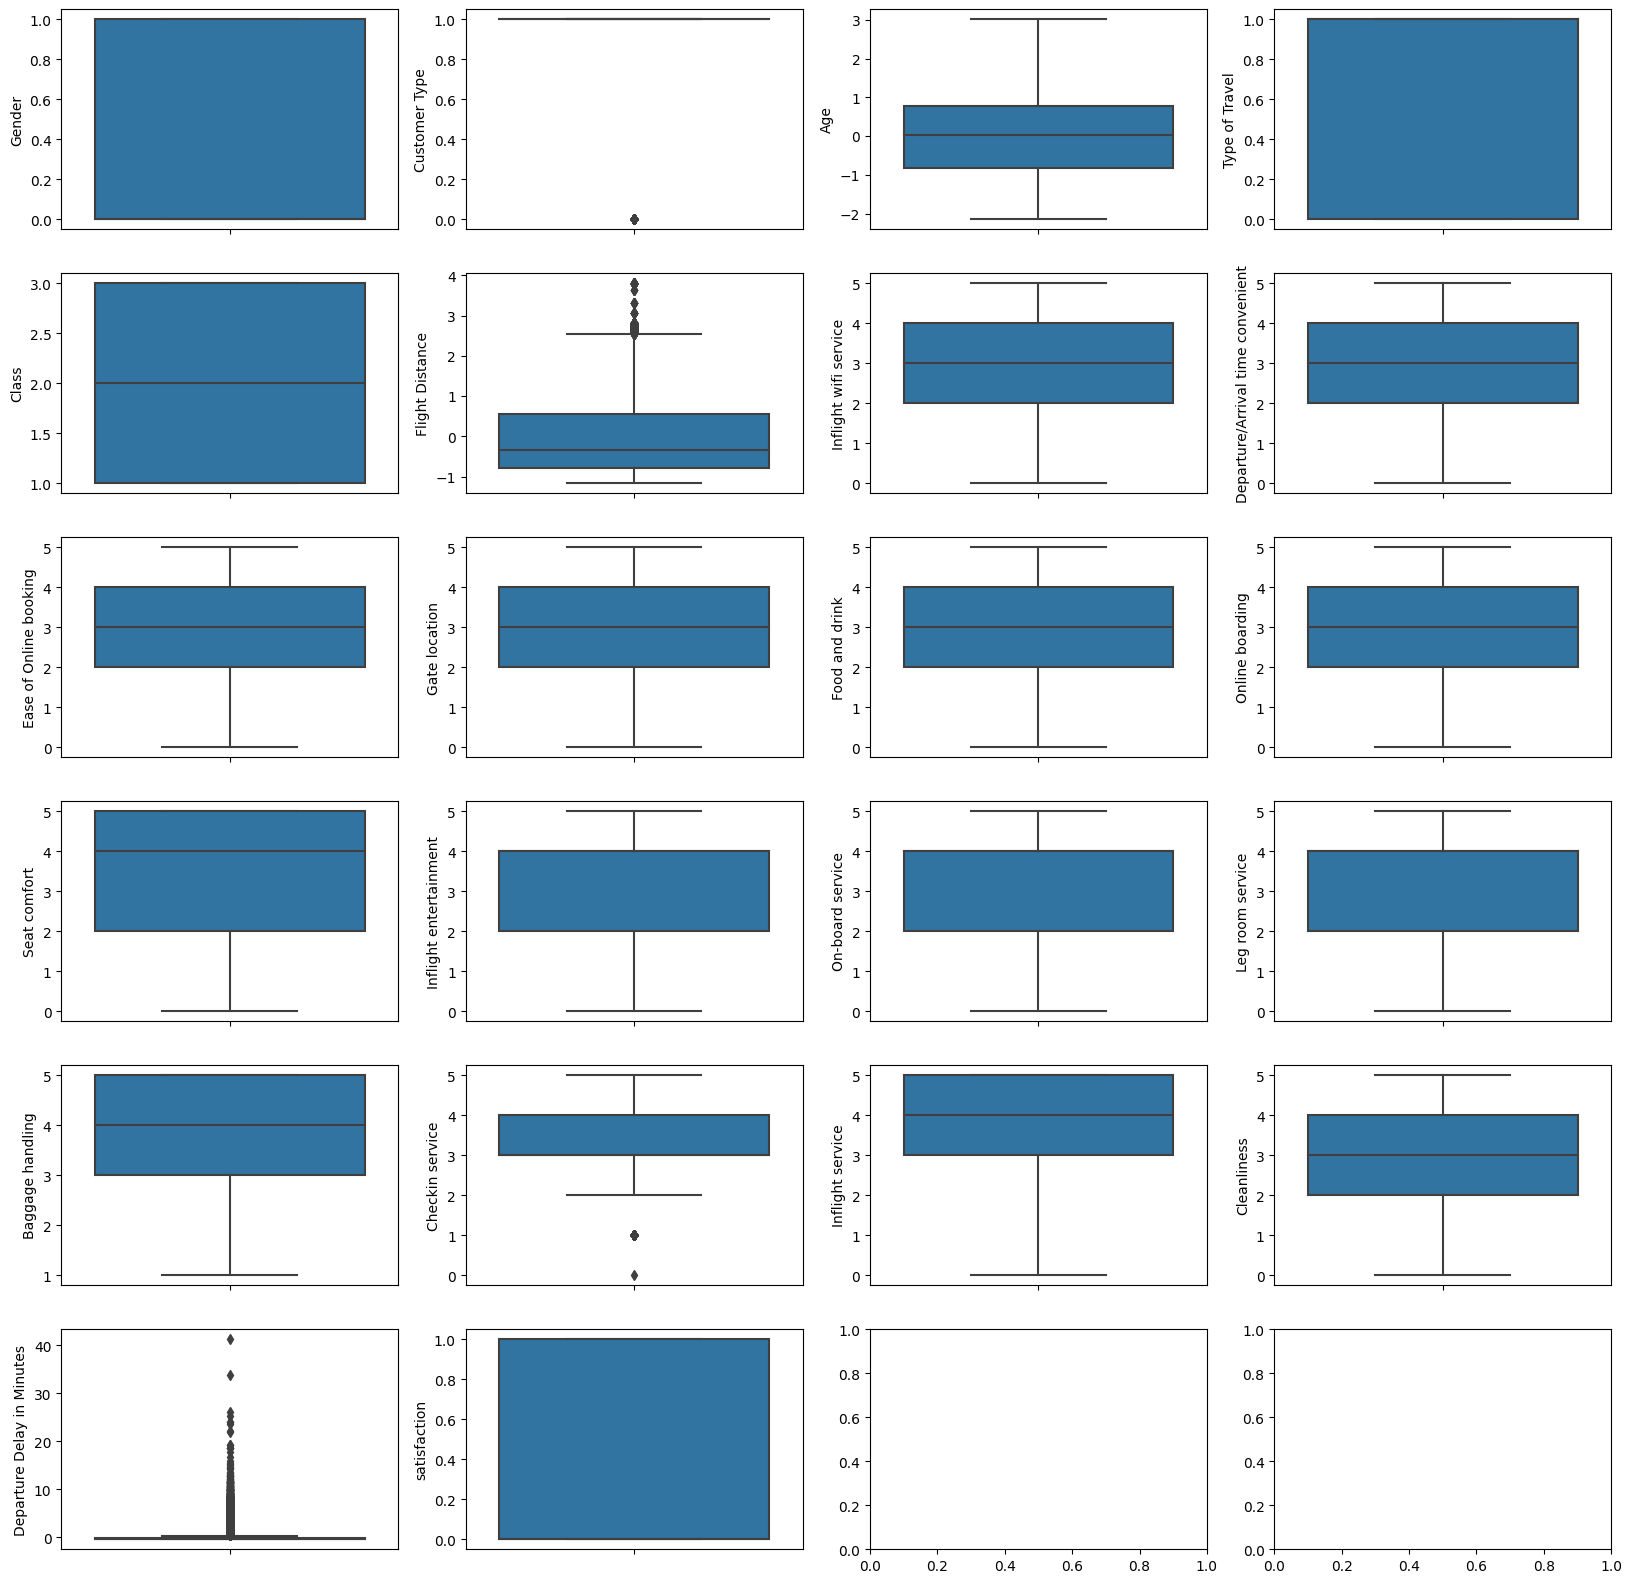

In [15]:
# Tratamiento de valores atípicos
train_df1_out = train_df1.copy()

# Sentar las bases de un "mosaico boxplot de 6x4 (para cubrir 22 variables)":
box_locs=pd.DataFrame(
{"vert":sorted(list(range(0,6))*4),
 "horiz":list(range(0,4))*6}
)

fig,axs=plt.subplots(ncols=4,nrows=6,figsize=(20,20))

for idx,i in enumerate(train_df1_out.columns):
    sns.boxplot(y=train_df1_out[i],ax=axs[box_locs.iloc[idx,0]][box_locs.iloc[idx,1]])

In [16]:
# Take indices of all the outliers:
outs_idx=[train_df1_out[train_df1_out['Flight Distance'] > 2.5]['Flight Distance'].index.astype('int'),
          train_df1_out[train_df1_out['Departure Delay in Minutes'] > 20]['Departure Delay in Minutes'].index.astype('int')]

# Select unique ones and sort them:
outs_idx=pd.Series(sorted(np.concatenate(outs_idx))).unique()

# Drop these rows from 'train_df1_out' and 'train_df1, don't forget to RESET INDICES afterwards:
train_df1_out.drop(index=outs_idx,inplace=True)
train_df1_out.reset_index(drop=True,inplace=True) # 101174 rows left


In [17]:
train_df1_out.shape

(101174, 22)

In [18]:
train_df1.shape

(103904, 22)

## Reducción dimensionalidad

In [19]:
#Cree un dataset reducido que proporcione el 85% de la varianza de entrada que debe explicarse
pca = PCA(n_components=0.85).fit(train_df1_out)

#Veamos cuántas componentes ha conservado PCA:
pca.n_components_

11

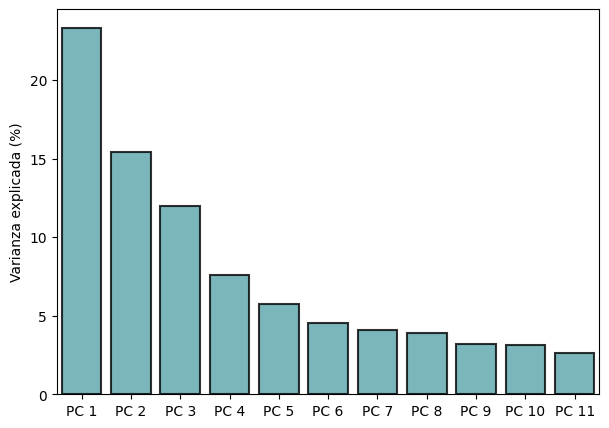

In [20]:
# --- Varianza explicada ---
PCA_variance = pd.DataFrame({'Varianza explicada (%)':
                             pca.explained_variance_ratio_*100})

fig, ax = plt.subplots(1, 1, figsize = (7, 5))

bar = sns.barplot(x = ['PC ' + str(i) for i in range(1, 12)],
                  y = PCA_variance['Varianza explicada (%)'],
                  linewidth = 1.5, edgecolor = 'k', color = '#4bafb8',
                  alpha = 0.8)

plt.show()

In [21]:
PCA_variance

,Varianza explicada (%)
0,23.328240
1,15.405791
2,11.997345
3,7.603402
4,5.759945
5,4.553510
6,4.088099
7,3.887373
8,3.229174
9,3.104133


In [22]:
#Por último, transforme "train_df1" de 22 columnas X_pca
X_pca = pca.fit_transform(train_df1_out)
X_pca

array([[-2.77991798e+00,  1.52172429e+00,  2.89077823e-01, ...,
         6.50595801e-01, -1.62936541e+00,  2.45522045e-01],
       [ 4.15009843e+00, -1.73781560e+00, -1.16809919e+00, ...,
        -5.49964625e-01, -9.20329204e-01, -1.50484574e+00],
       [-2.93912558e+00,  2.88135337e+00,  8.61282754e-01, ...,
         2.34841890e-02, -8.88147669e-01, -2.74487704e-02],
       ...,
       [ 7.33921519e-02,  3.76487273e+00, -1.62720933e-01, ...,
        -9.74254620e-02, -1.50889844e-01, -3.92367344e-01],
       [ 4.91901337e+00,  2.51993915e-01, -2.59972982e+00, ...,
        -1.21668657e+00,  1.53306545e+00,  1.82430088e+00],
       [ 5.33702715e+00, -1.14347737e+00, -6.20305761e-01, ...,
        -4.00833551e-03, -1.41463992e+00, -8.95495591e-01]])

## Clustering Algorithm: K-Means

### Dataset  Original Escalado

In [23]:
# Número optimo de K
inertia_list = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3)
    kmeans.fit(train_df1_out)
    inertia_list.append(kmeans.inertia_)

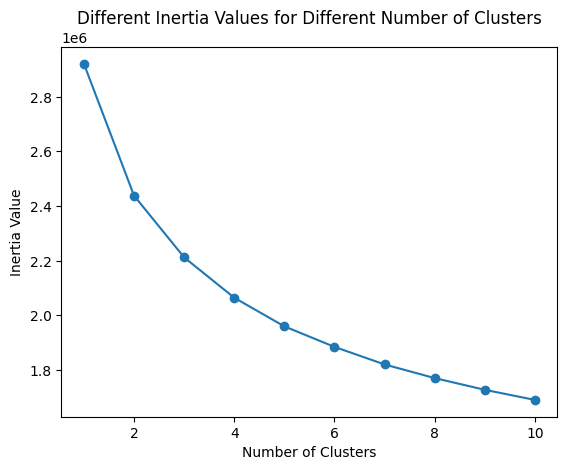

In [24]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list)
plt.scatter(range(1,11),inertia_list)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [25]:
# Seleccion automatica del numero k
kl = KneeLocator(range(1, 11),
                 inertia_list, curve="convex",
                 direction="decreasing")
kl.elbow

4

In [26]:
kmeans_constants = {"init": "random", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 4, **kmeans_constants)
model_kmeans.fit(train_df1_out)

KMeans(init='random', max_iter=500, n_clusters=4, n_init=100, random_state=42)

**Evaluación del algoritmos**

**Calinski Harabasz Score:**

El índice Calinski-Harabasz se basa en la comparación de la relación ponderada entre la suma de los cuadrados (la medida de la separación del clúster) y la suma de los cuadrados dentro del clúster (la medida de cómo se empaquetan estrechamente los puntos dentro de un clúster).

Las soluciones de clúster con valores más grandes del índice corresponden a soluciones "mejores" que las soluciones de clúster con valores más pequeños.

In [27]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(train_df1_out, model_kmeans.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(train_df1_out, model_kmeans.labels_))

 ### K-MEANS ###
Inertia:  2064980.0618141894
Silhouette Score:  0.12631076653733772
Calinski harabasz score:  13965.41685564466


In [28]:
# Predicción de los clusters
Cluster_1 = model_kmeans.fit_predict(train_df1_out)
Cluster_1

array([1, 2, 1, ..., 1, 2, 2], dtype=int32)

In [29]:
# Vamos a adjuntar 'Cluster_1' como una nueva variable a 'train_df1_out':
df_final = train_df1_out.copy()
df_final['Cluster_1']= Cluster_1

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Cluster_1
0,1,1,-1.745279,0,2,-0.731539,3,4,3,1,...,5,4,3,4,4,5,5,0.266393,0,1
1,1,0,-0.951360,1,3,-0.957184,3,2,3,3,...,1,1,5,3,1,4,1,-0.361375,0,2
2,0,1,-0.885200,1,3,-0.047584,2,2,2,2,...,5,4,3,4,4,4,5,-0.387532,1,1
3,0,1,-0.951360,1,3,-0.629246,2,5,5,5,...,2,2,5,3,1,4,2,-0.099805,0,2
4,1,1,1.430397,1,3,-0.978244,3,3,3,3,...,3,3,4,4,3,3,3,-0.387532,1,0


In [30]:
df_final.Cluster_1.unique()

array([1, 2, 0, 3], dtype=int32)

### Dataset Reducido

In [31]:
# Número optimo de K
inertia_list = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3)
    kmeans.fit(X_pca)
    inertia_list.append(kmeans.inertia_)

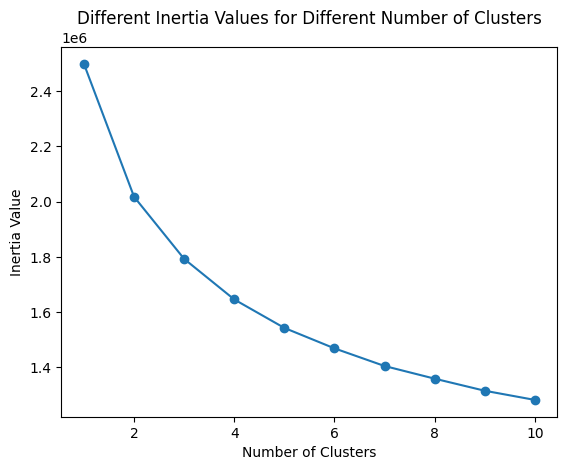

In [32]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list)
plt.scatter(range(1,11),inertia_list)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [33]:
# Seleccion automatica del numero k
kl = KneeLocator(range(1, 11),
                 inertia_list, curve="convex",
                 direction="decreasing")
kl.elbow

4

In [34]:
kmeans_constants = {"init": "random", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans_pca = KMeans(n_clusters = 4, **kmeans_constants)
model_kmeans_pca.fit(X_pca)

KMeans(init='random', max_iter=500, n_clusters=4, n_init=100, random_state=42)

In [35]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans_pca.inertia_)
print('Silhouette Score: ', silhouette_score(X_pca, model_kmeans_pca.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca, model_kmeans_pca.labels_))

 ### K-MEANS ###
Inertia:  1644862.0628954028
Silhouette Score:  0.1512119147429192
Calinski harabasz score:  17511.953699582133


In [37]:
# Predicción de los clusters
Cluster_2 = model_kmeans.fit_predict(X_pca)

df_final['Cluster_2']= Cluster_2

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Cluster_1,Cluster_2
0,1,1,-1.745279,0,2,-0.731539,3,4,3,1,...,4,3,4,4,5,5,0.266393,0,1,2
1,1,0,-0.951360,1,3,-0.957184,3,2,3,3,...,1,5,3,1,4,1,-0.361375,0,2,1
2,0,1,-0.885200,1,3,-0.047584,2,2,2,2,...,4,3,4,4,4,5,-0.387532,1,1,2


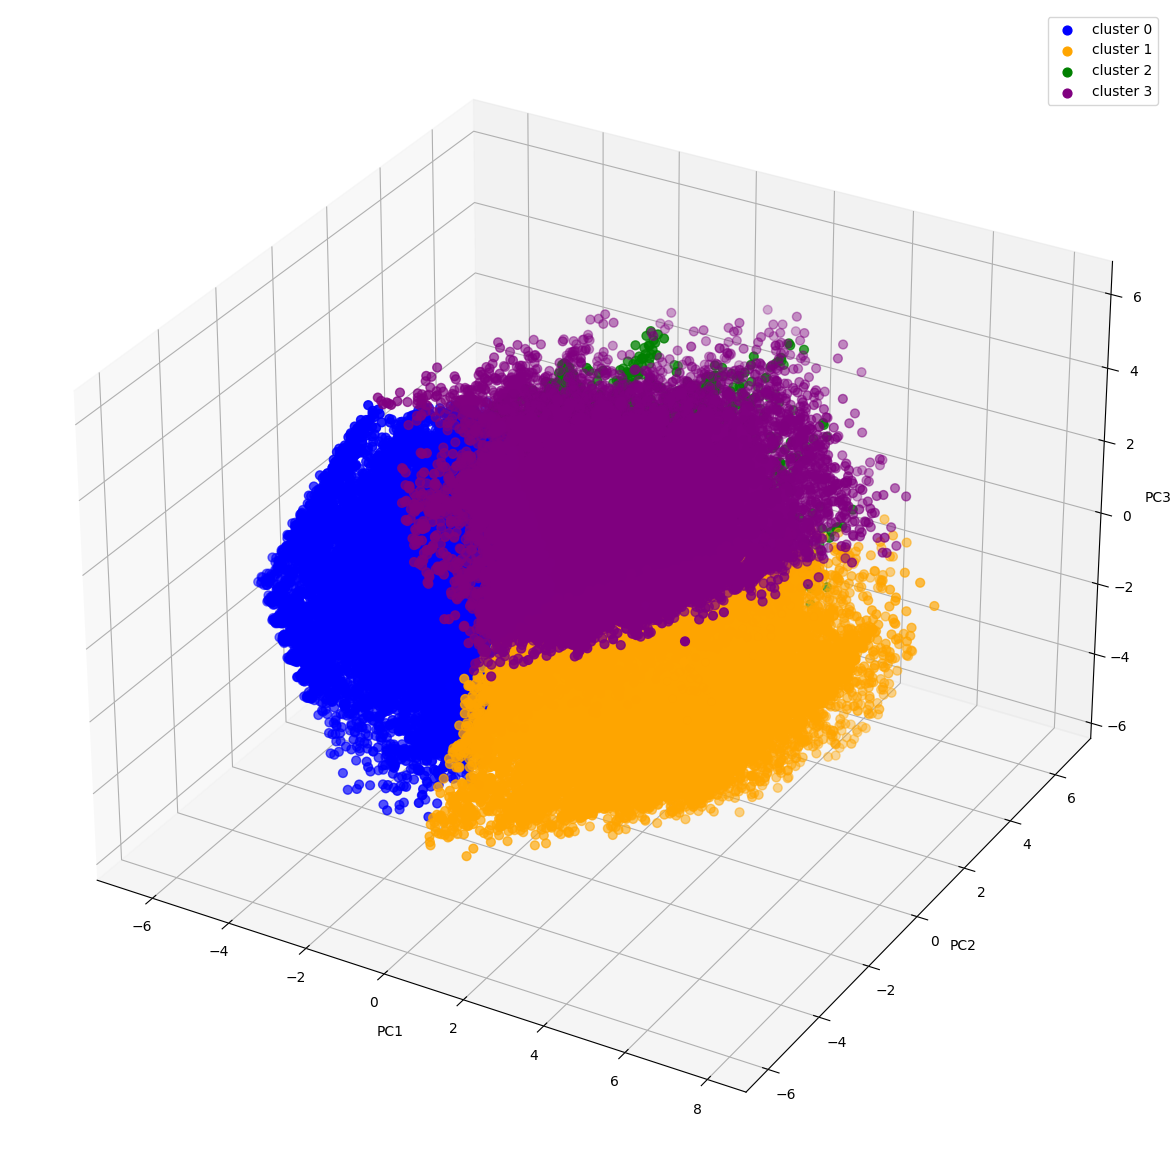

In [38]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[Cluster_2 == 0,0],X_pca[Cluster_2 == 0,1],X_pca[Cluster_2 == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X_pca[Cluster_2 == 1,0],X_pca[Cluster_2 == 1,1],X_pca[Cluster_2 == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(X_pca[Cluster_2 == 2,0],X_pca[Cluster_2 == 2,1],X_pca[Cluster_2 == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(X_pca[Cluster_2 == 3,0],X_pca[Cluster_2 == 3,1],X_pca[Cluster_2 == 3,2], s = 40 , color = 'purple', label = "cluster 3")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

## Clustering Algorithm: DBSCAN

### Dataset Original

In [40]:
from sklearn.neighbors import NearestNeighbors

# --- Selección de hiperparámetros eps ---

# --- Gráfica de distancias K --
neighbors = NearestNeighbors(n_neighbors = 2)
neighbors.fit(train_df1_out)

distances, *other = neighbors.kneighbors(train_df1_out)
distances = distances[:, 1]
print(distances.shape)
distances = np.sort(distances, axis = 0)
distances

(101174,)


array([1.00286569e-03, 1.00286569e-03, 4.01146283e-03, ...,
       6.57661830e+00, 6.86355801e+00, 6.91303222e+00])

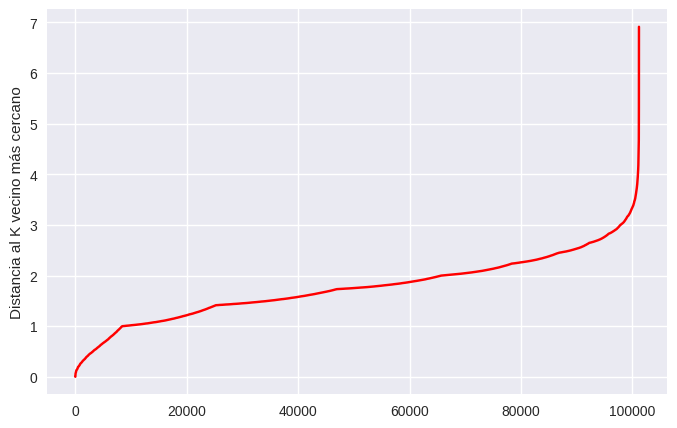

In [41]:
plt.style.use('seaborn')
plt.figure(figsize = (8, 5))
plt.plot(distances, color = 'red')
plt.ylabel('Distancia al K vecino más cercano')
plt.show()

In [42]:
# --- Selección del punto de curvatura máxima ---
kl = KneeLocator(range(len(distances)), distances, curve = 'convex', direction = 'increasing')
kl.elbow

100926

In [43]:
# --- Epsilon óptimo --
epsilon = distances[kl.elbow]
epsilon

3.8990725501554384

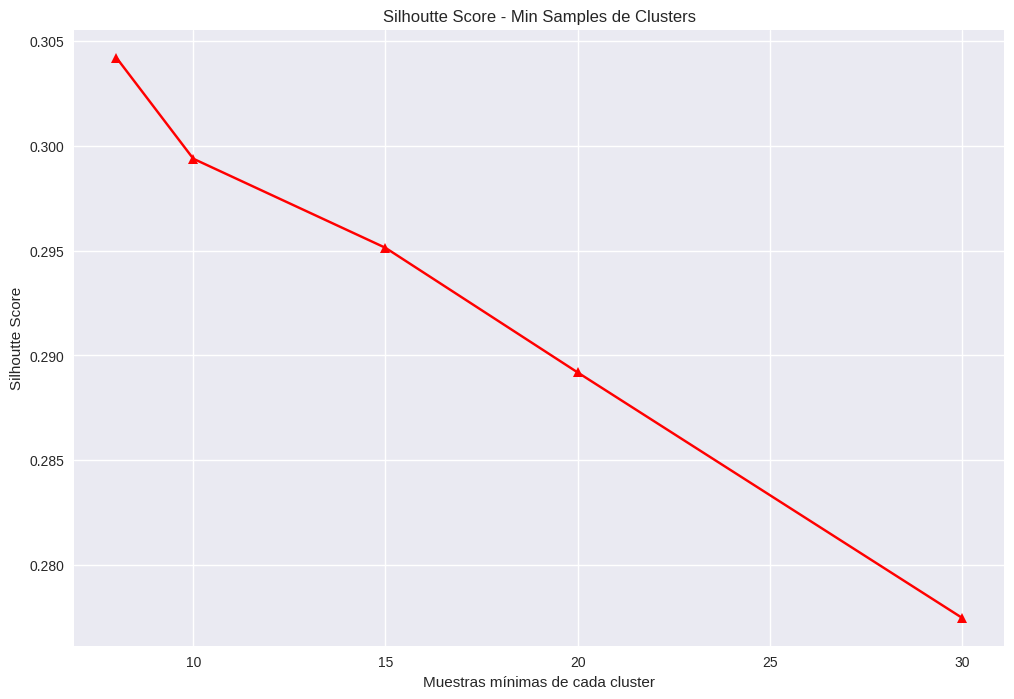

In [44]:
# --- Selección de hiperparámetros min_sample ---
silhoutte_coefs = []

for min_points in [8, 10, 15, 20, 30]:
    model_d = DBSCAN(eps = epsilon, min_samples = min_points)
    model_d.fit(train_df1_out)
    silhoutte_coefs.append(silhouette_score(train_df1_out, model_d.labels_))

plt.figure(figsize = (12, 8))
plt.plot([8, 10, 15, 20, 30], silhoutte_coefs, color = 'r', marker = '^')
plt.xlabel('Muestras mínimas de cada cluster')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score - Min Samples de Clusters')
plt.show()

In [45]:
# --- Modelo DBSCAN ---
model_db = DBSCAN(eps = epsilon, min_samples = 8, n_jobs=-1)
model_db.fit(train_df1_out)

DBSCAN(eps=3.8990725501554384, min_samples=8, n_jobs=-1)

In [46]:
# --- Evaluación del modelo DBSCAN ---
print(" ### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(train_df1_out, model_db.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(train_df1_out, model_db.labels_))

 ### DBSCAN ###
Silhouette Score:  0.3041885817674529
Calinski harabasz score:  404.6726867763104


In [47]:
# Predicción de los clusters
Cluster_3 = model_db.fit_predict(train_df1_out)

df_final['Cluster_3']= Cluster_3

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Cluster_1,Cluster_2,Cluster_3
0,1,1,-1.745279,0,2,-0.731539,3,4,3,1,...,3,4,4,5,5,0.266393,0,1,2,0
1,1,0,-0.951360,1,3,-0.957184,3,2,3,3,...,5,3,1,4,1,-0.361375,0,2,1,0
2,0,1,-0.885200,1,3,-0.047584,2,2,2,2,...,3,4,4,4,5,-0.387532,1,1,2,0


In [ ]:
df_final['Cluster_3'].value_counts()

 0    103419
-1       418
Name: Cluster_3, dtype: int64

### Dataset reducido

In [48]:
# --- Selección de hiperparámetros eps ---

# --- Gráfica de distancias K --
neighbors = NearestNeighbors(n_neighbors = 2)
neighbors.fit(X_pca)

distances, *other = neighbors.kneighbors(X_pca)
distances = distances[:, 1]
print(distances.shape)
distances = np.sort(distances, axis = 0)
distances

(101174,)


array([6.56269256e-04, 6.56269256e-04, 2.62507702e-03, ...,
       4.94876397e+00, 5.63930563e+00, 5.76252684e+00])

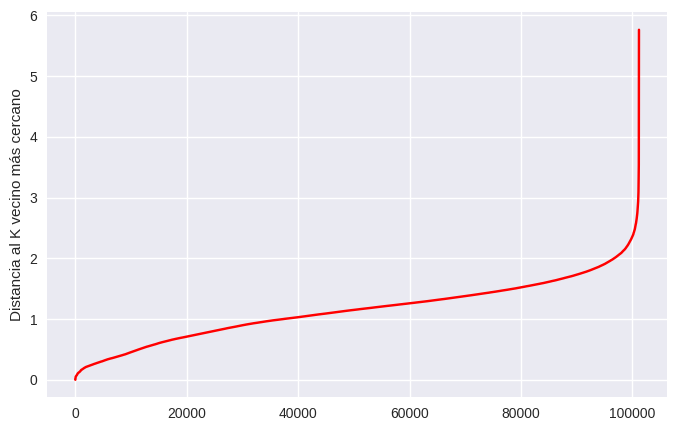

In [51]:
plt.style.use('seaborn')
plt.figure(figsize = (8, 5))
plt.plot(distances, color = 'red')
plt.ylabel('Distancia al K vecino más cercano')
plt.show()

In [49]:
# --- Selección del punto de curvatura máxima ---
kl = KneeLocator(range(len(distances)), distances, curve = 'convex', direction = 'increasing')
kl.elbow

100855

In [50]:
# --- Epsilon óptimo --
epsilon = distances[kl.elbow]
epsilon

2.7241544615613034

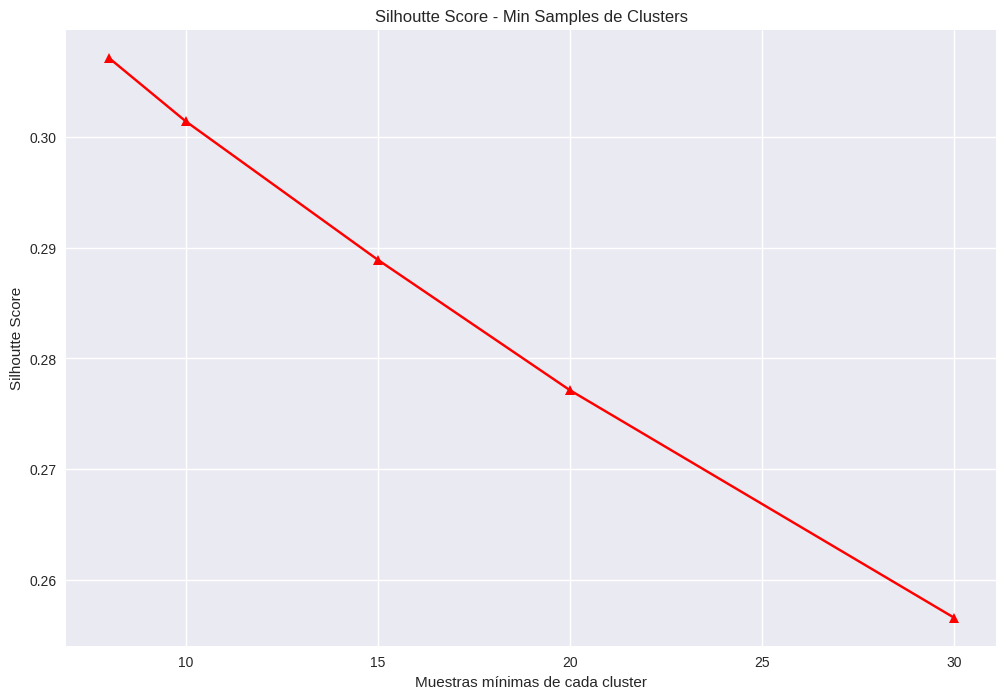

In [52]:
# --- Selección de hiperparámetros min_sample ---
silhoutte_coefs = []

for min_points in [8, 10, 15, 20, 30]:
    model_d = DBSCAN(eps = epsilon, min_samples = min_points)
    model_d.fit(X_pca)
    silhoutte_coefs.append(silhouette_score(X_pca, model_d.labels_))

plt.figure(figsize = (12, 8))
plt.plot([8, 10, 15, 20, 30], silhoutte_coefs, color = 'r', marker = '^')
plt.xlabel('Muestras mínimas de cada cluster')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score - Min Samples de Clusters')
plt.show()

In [53]:
# --- Modelo DBSCAN ---
model_db_pca = DBSCAN(eps = 0.5, min_samples = 8)
model_db_pca.fit(X_pca)

DBSCAN(eps=2.7241544615613034, min_samples=8)

In [54]:
# --- Evaluación del modelo DBSCAN ---
print(" ### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(X_pca, model_db_pca.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca, model_db_pca.labels_))

 ### DBSCAN ###
Silhouette Score:  0.30718186425729516
Calinski harabasz score:  755.3969716043933


In [55]:
# Predicción de los clusters
Cluster_4 = model_db_pca.fit_predict(X_pca)

df_final['Cluster_4']= Cluster_4

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,1,1,-1.745279,0,2,-0.731539,3,4,3,1,...,4,4,5,5,0.266393,0,1,2,0,0
1,1,0,-0.951360,1,3,-0.957184,3,2,3,3,...,3,1,4,1,-0.361375,0,2,1,0,0
2,0,1,-0.885200,1,3,-0.047584,2,2,2,2,...,4,4,4,5,-0.387532,1,1,2,0,0


In [56]:
df_final['Cluster_4'].value_counts()

 0    100592
-1       582
Name: Cluster_4, dtype: int64

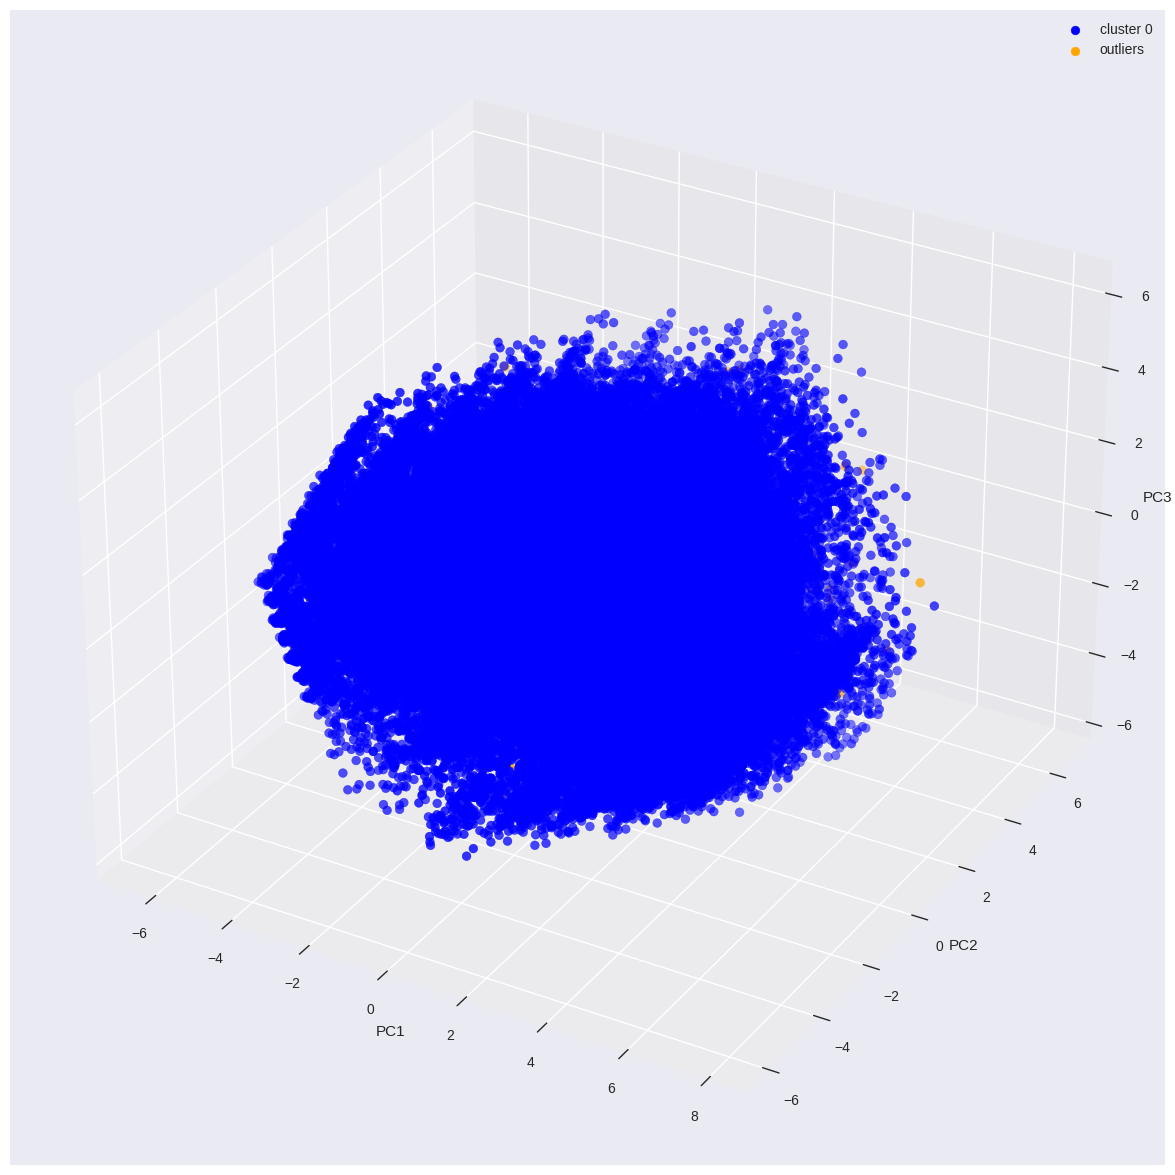

In [58]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[Cluster_4 == 0,0],X_pca[Cluster_4 == 0,1],X_pca[Cluster_4 == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X_pca[Cluster_4 == -1,0],X_pca[Cluster_4 == -1,1],X_pca[Cluster_4 == -1,2], s = 40 , color = 'orange', label = "outliers")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

## Clustering Algorithm: Gaussian Mixture Model

### Dataset Original

Text(0.5, 0, 'Número de Clusters')

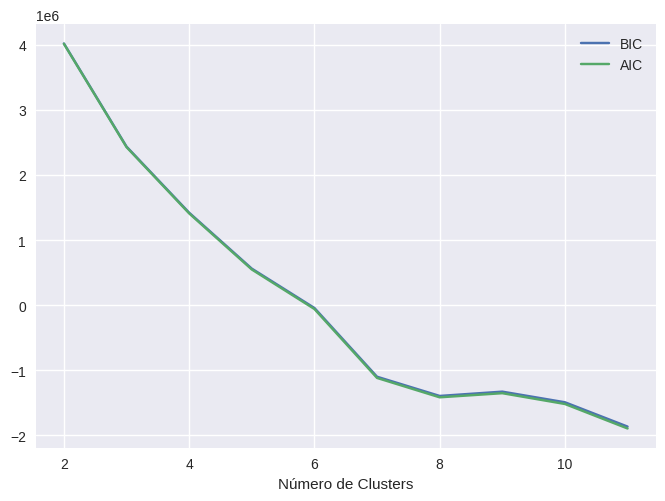

In [59]:
# --- Estimación de hiperparámetros ---

n_components = np.arange(2, 12)

models_g = [GaussianMixture(n_components=n, random_state=123).fit(train_df1_out) for n in n_components]

plt.plot(n_components, [m.bic(train_df1_out) for m in models_g], label="BIC")
plt.plot(n_components, [m.aic(train_df1_out) for m in models_g], label="AIC")
plt.legend()
plt.xlabel("Número de Clusters")

In [60]:
# --- Modelo GMM ---
model_gmm = GaussianMixture(n_components=6, random_state=123, covariance_type = 'full').fit(train_df1_out)

In [61]:
# --- Evaluación del modelo GMM ---
labels_ = model_gmm.predict(train_df1_out)

print(" ### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(train_df1_out, labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(train_df1_out, labels_))

 ### DBSCAN ###
Silhouette Score:  0.007985707532885924
Calinski harabasz score:  3353.7057573119237


In [62]:
# Predicción de los clusters
Cluster_5 = model_gmm.fit_predict(train_df1_out)

df_final['Cluster_5']= Cluster_5

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5
0,1,1,-1.745279,0,2,-0.731539,3,4,3,1,...,4,5,5,0.266393,0,1,2,0,0,0
1,1,0,-0.951360,1,3,-0.957184,3,2,3,3,...,1,4,1,-0.361375,0,2,1,0,0,0
2,0,1,-0.885200,1,3,-0.047584,2,2,2,2,...,4,4,5,-0.387532,1,1,2,0,0,1


In [63]:
df_final['Cluster_5'].value_counts()

0    40803
3    24407
5    14991
1     9382
2     8520
4     3071
Name: Cluster_5, dtype: int64

### Dataset reducido

Text(0.5, 0, 'Número de Clusters')

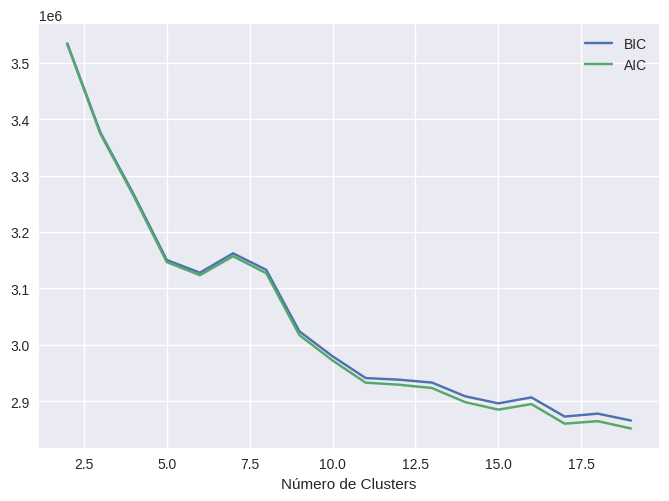

In [64]:
# --- Estimación de hiperparámetros ---

n_components = np.arange(2, 20)

models_g = [GaussianMixture(n_components=n, random_state=123).fit(X_pca) for n in n_components]

plt.plot(n_components, [m.bic(X_pca) for m in models_g], label="BIC")
plt.plot(n_components, [m.aic(X_pca) for m in models_g], label="AIC")
plt.legend()
plt.xlabel("Número de Clusters")

In [74]:
# --- Modelo GMM ---
model_gmm_pca = GaussianMixture(n_components=5, random_state=123, covariance_type = 'full').fit(X_pca)

In [75]:
# --- Evaluación del modelo GMM ---
labels_ = model_gmm_pca.predict(X_pca)

print(" ### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(X_pca, labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca, labels_))

 ### DBSCAN ###
Silhouette Score:  -0.011856763068476356
Calinski harabasz score:  3035.9744421489036


In [76]:
# Predicción de los clusters
Cluster_6 = model_gmm_pca.fit_predict(X_pca)

df_final['Cluster_6'] = Cluster_6

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6
0,1,1,-1.745279,0,2,-0.731539,3,4,3,1,...,5,5,0.266393,0,1,2,0,0,0,1
1,1,0,-0.951360,1,3,-0.957184,3,2,3,3,...,4,1,-0.361375,0,2,1,0,0,0,0
2,0,1,-0.885200,1,3,-0.047584,2,2,2,2,...,4,5,-0.387532,1,1,2,0,0,1,2


In [77]:
df_final['Cluster_6'].value_counts()

0    36259
2    24069
3    14819
1    13956
4    12071
Name: Cluster_6, dtype: int64

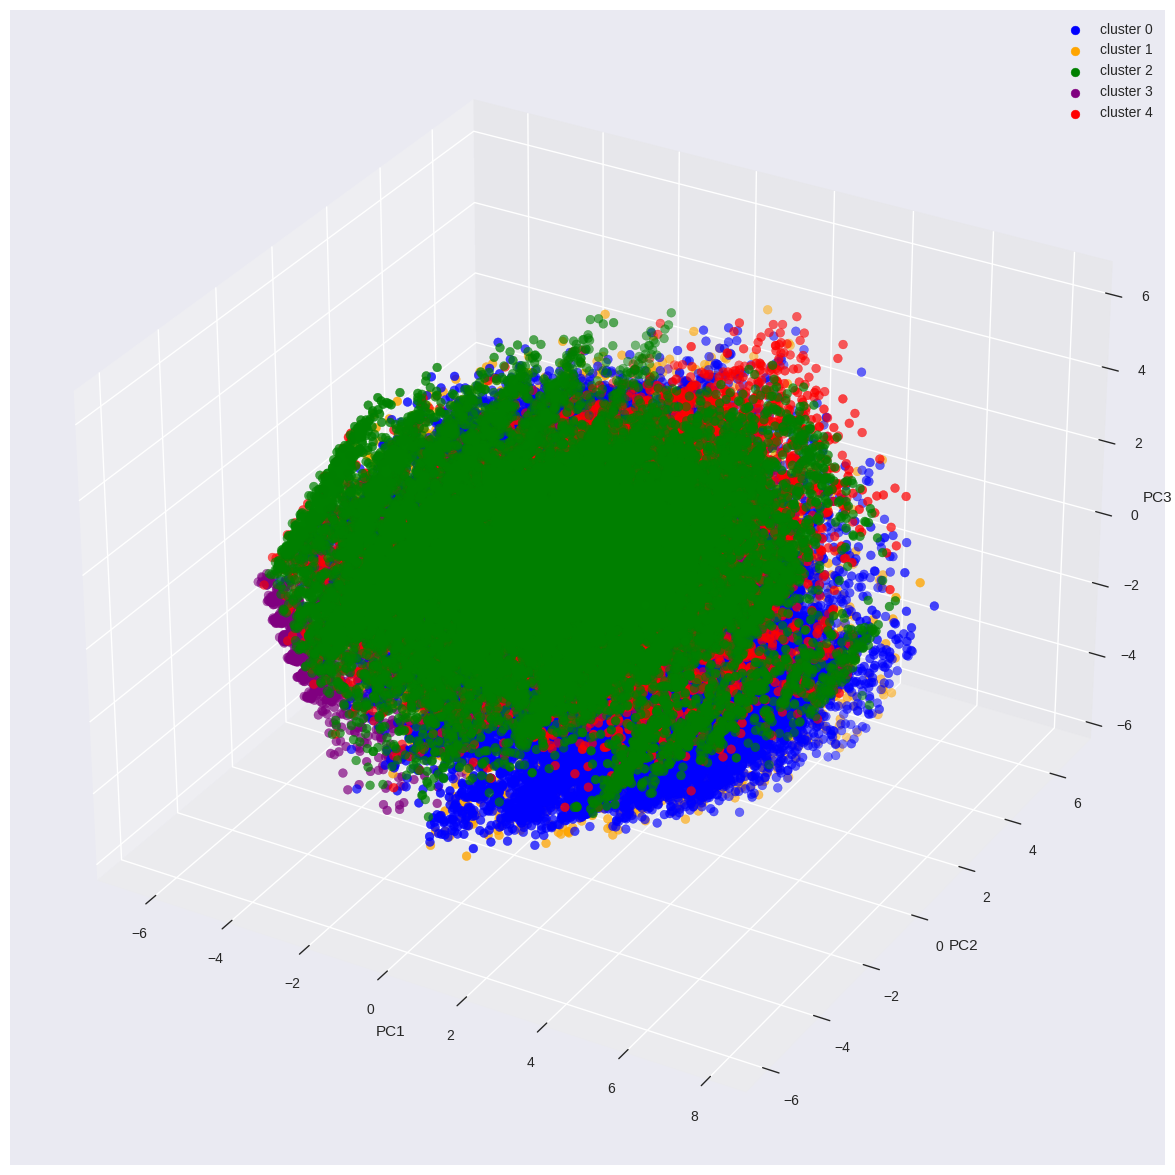

In [78]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[Cluster_6 == 0,0],X_pca[Cluster_6 == 0,1],X_pca[Cluster_6 == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X_pca[Cluster_6 == 1,0],X_pca[Cluster_6 == 1,1],X_pca[Cluster_6 == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(X_pca[Cluster_6 == 2,0],X_pca[Cluster_6 == 2,1],X_pca[Cluster_6 == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(X_pca[Cluster_6 == 3,0],X_pca[Cluster_6 == 3,1],X_pca[Cluster_6 == 3,2], s = 40 , color = 'purple', label = "cluster 3")
ax.scatter(X_pca[Cluster_6 == 4,0],X_pca[Cluster_6 == 4,1],X_pca[Cluster_6 == 4,2], s = 40 , color = 'red', label = "cluster 4")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

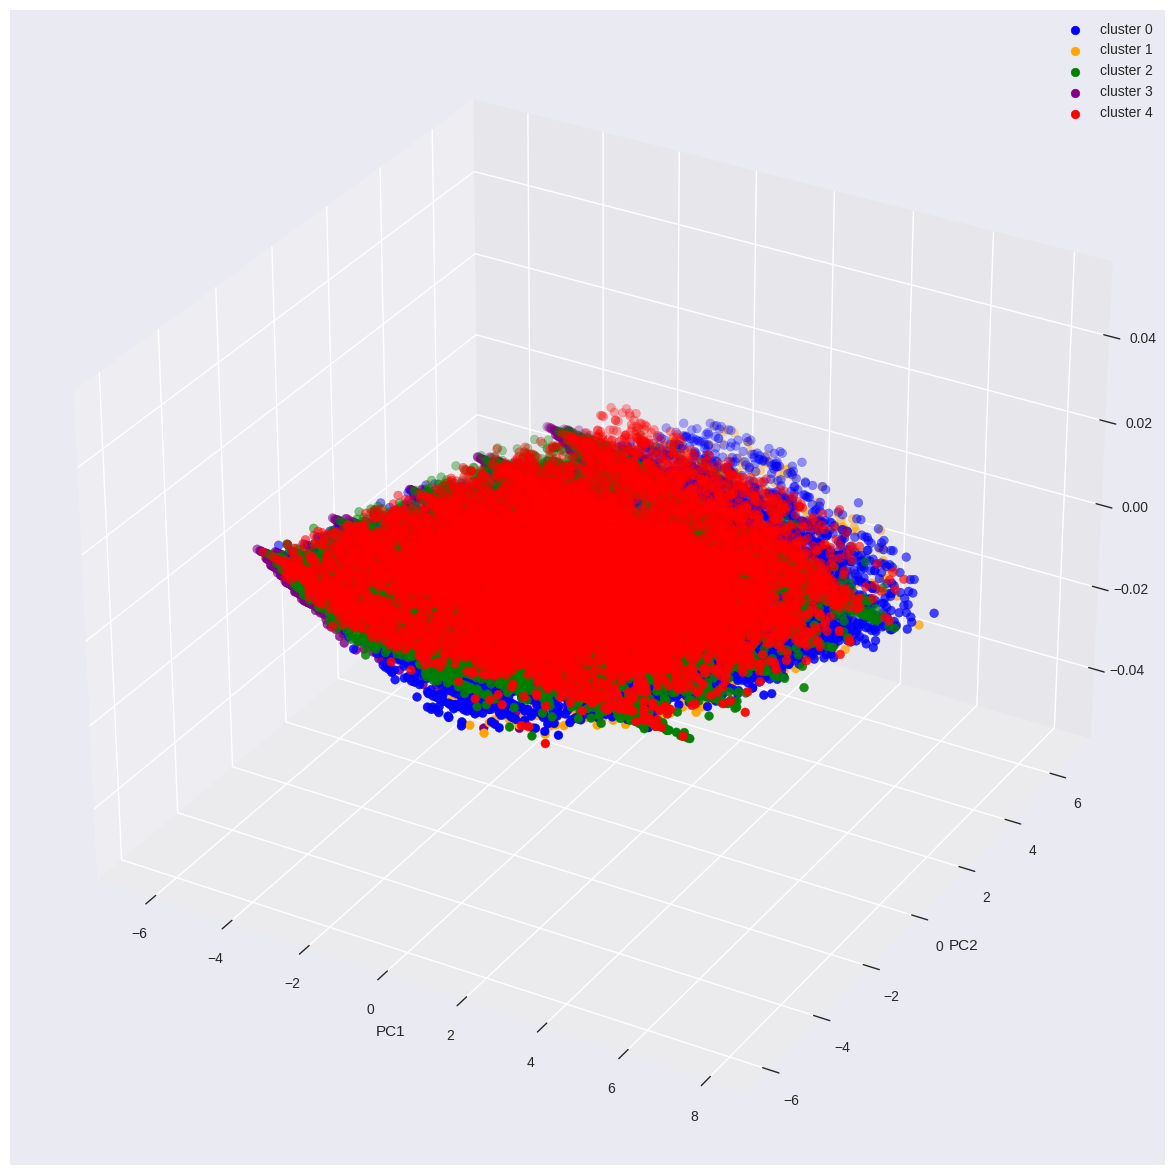

In [79]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[Cluster_6 == 0,0],X_pca[Cluster_6 == 0,1], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X_pca[Cluster_6 == 1,0],X_pca[Cluster_6 == 1,1], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(X_pca[Cluster_6 == 2,0],X_pca[Cluster_6 == 2,1], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(X_pca[Cluster_6 == 3,0],X_pca[Cluster_6 == 3,1], s = 40 , color = 'purple', label = "cluster 3")
ax.scatter(X_pca[Cluster_6 == 4,0],X_pca[Cluster_6 == 4,1], s = 40 , color = 'red', label = "cluster 4")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()